In [ ]:
!pip install pandas scikit-learn openpyxl

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
df = pd.read_excel("/content/final_data.xlsx")

In [ ]:
df.head()

,Date,US TBill 10Y Yield(%),Fed Funds Rate (%)_shifted(1M),Building permits(in thousands)_shifted(1M),German Bund Yield_shifted(1M),Consumer Sentiment Index_shifted(1M),Debt to GDP_shifted(1M),Crude Oil Front Month Future (USD/bbl)_shifted(1M),S&P 500(%)_shifted(1M),Economic_Stress_shifted(1M)
0,1991-03-01,8.061,6.25,853,8.329,70.4,-3.877,19.16,6.728113,400.21542
1,1991-04-01,8.013,6.12,911,8.484,87.7,-3.675,19.63,2.220285,410.02164
2,1991-05-01,8.059,5.91,916,8.341,81.8,-3.813,20.96,0.034646,405.03108
3,1991-06-01,8.227,5.78,991,8.266,78.3,-3.991,21.13,3.857733,421.30503
4,1991-07-01,8.147,5.90,964,8.492,82.1,-3.852,20.56,-4.789267,424.70466


In [ ]:
target = 'US TBill 10Y Yield(%)'

In [ ]:
df['Yield_lag1'] = df[target].shift(1)
df['Yield_lag3'] = df[target].shift(3)
df['Yield_lag6'] = df[target].shift(6)

df['Yield_ma3'] = df[target].rolling(window=3).mean()
df['Yield_ma6'] = df[target].rolling(window=6).mean()
df['Yield_ma12'] = df[target].rolling(window=12).mean()

In [ ]:
df = df.dropna().reset_index(drop=True)

In [ ]:
X = df.drop(columns=['Date', target])
y = df[target]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
train_dates = df['Date'].iloc[y_train.index]
test_dates = df['Date'].iloc[y_test.index]

In [ ]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
base_tree = DecisionTreeRegressor()
ada = AdaBoostRegressor(estimator=base_tree, random_state=42)

In [ ]:
param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.1, 0.2],
    'estimator__max_depth': [3, 4],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

In [ ]:
grid_search = GridSearchCV(ada, param_grid, cv=TimeSeriesSplit(n_splits=5),
                           scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [ ]:
print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 500}


In [ ]:
y_train_pred = best_model.predict(X_train_scaled)
y_test_pred = best_model.predict(X_test_scaled)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

In [ ]:
def weighted_mape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

train_wmape = weighted_mape(y_train, y_train_pred)
test_wmape = weighted_mape(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

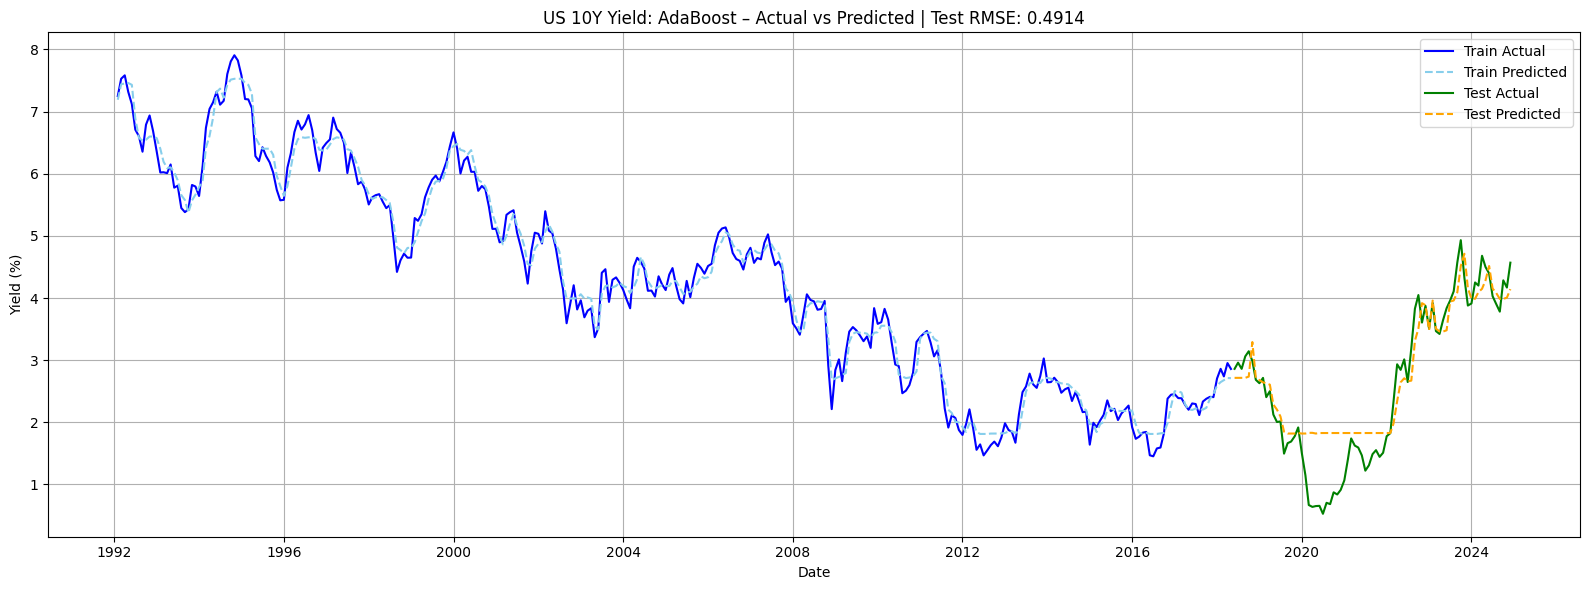

In [ ]:
plt.figure(figsize=(16, 6))
plt.plot(train_dates, y_train, label='Train Actual', color='blue')
plt.plot(train_dates, y_train_pred, label='Train Predicted', color='skyblue', linestyle='--')
plt.plot(test_dates, y_test, label='Test Actual', color='green')
plt.plot(test_dates, y_test_pred, label='Test Predicted', color='orange', linestyle='--')
plt.title(f'US 10Y Yield: AdaBoost – Actual vs Predicted | Test RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.4f}')
plt.xlabel("Date")
plt.ylabel("Yield (%)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

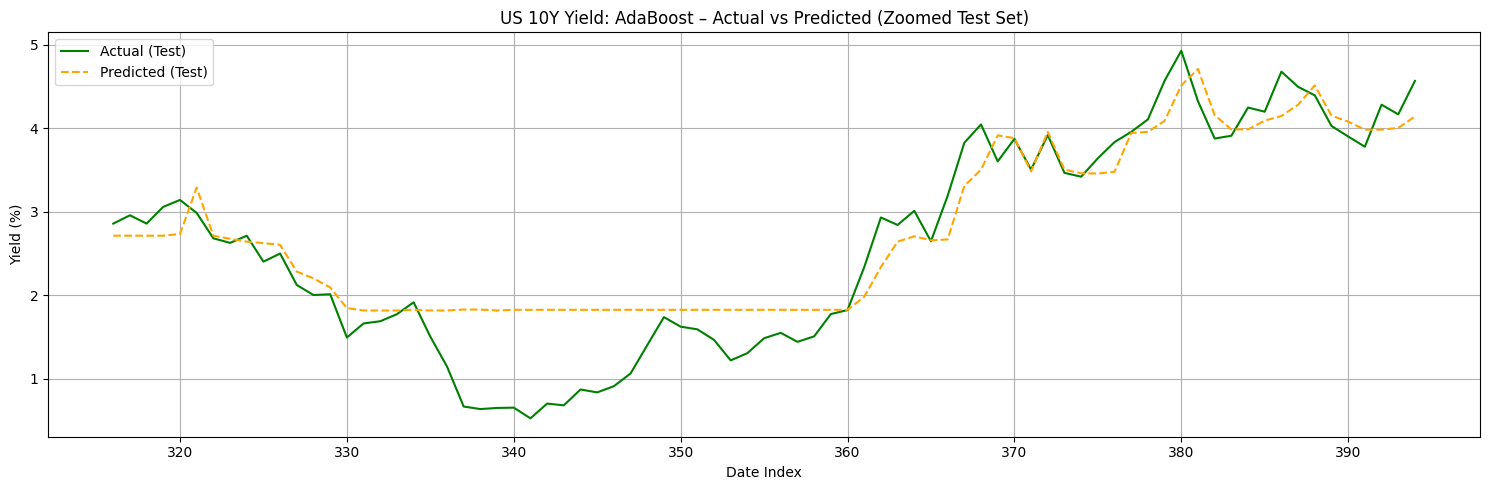

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(y_test.index, y_test.values, label='Actual (Test)', color='green')
plt.plot(y_test.index, y_test_pred, label='Predicted (Test)', color='orange', linestyle='--')
plt.xlabel('Date Index')
plt.ylabel('Yield (%)')
plt.title('US 10Y Yield: AdaBoost – Actual vs Predicted (Zoomed Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
print("Best Parameters:", grid_search.best_params_)
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train WMAPE: {train_wmape:.2f}%")
print(f"Test WMAPE: {test_wmape:.2f}%")

Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 500}
Train RMSE: 0.1912
Test RMSE: 0.4914
Train MAE: 0.1583
Test MAE: 0.3597
Train R²: 0.9873
Test R²: 0.8492
Train WMAPE: 3.67%
Test WMAPE: 13.73%


In [ ]:
params_df = pd.DataFrame(list(grid_search.best_params_.items()), columns=['Parameter', 'Value'])
print(params_df.to_string(index=False))

                   Parameter  Value
        estimator__max_depth    3.0
 estimator__min_samples_leaf    2.0
estimator__min_samples_split    2.0
               learning_rate    0.1
                n_estimators  500.0


In [ ]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data (ensure the file path is correct)
df = pd.read_excel("/content/final_data.xlsx")

target = 'US TBill 10Y Yield(%)'

# Feature engineering
df['Yield_lag1'] = df[target].shift(1)
df['Yield_lag3'] = df[target].shift(3)
df['Yield_lag6'] = df[target].shift(6)
df['Yield_ma3'] = df[target].rolling(window=3).mean()
df['Yield_ma6'] = df[target].rolling(window=6).mean()
df['Yield_ma12'] = df[target].rolling(window=12).mean()
df = df.dropna().reset_index(drop=True)

X = df.drop(columns=['Date', target])
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

base_tree = DecisionTreeRegressor()
ada = AdaBoostRegressor(estimator=base_tree, random_state=42)

param_grid = {
    'n_estimators': [500, 800],
    'learning_rate': [0.1, 0.2],
    'estimator__max_depth': [3, 4],
    'estimator__min_samples_split': [2, 5],
    'estimator__min_samples_leaf': [1, 2]
}

grid_search = GridSearchCV(
    ada,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5),
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=0
)

def weighted_mape(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Function to run the full AdaBoost pipeline
def run_ada_boost():
    grid_search.fit(X_train_scaled, y_train)
    best_model = grid_search.best_estimator_

    y_train_pred = best_model.predict(X_train_scaled)
    y_test_pred = best_model.predict(X_test_scaled)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_wmape = weighted_mape(y_train, y_train_pred)
    test_wmape = weighted_mape(y_test, y_test_pred)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    return (train_rmse, test_rmse, train_r2, test_r2, train_wmape, test_wmape, train_mae, test_mae, grid_search.best_params_)

# Measure average running time
num_runs = 5  # Increase for more robust timing
running_times = []
results = []

for _ in range(num_runs):
    start_time = time.time()
    result = run_ada_boost()
    end_time = time.time()
    running_times.append(end_time - start_time)
    results.append(result)

average_time = sum(running_times) / num_runs

# Print average running time and last run results
print(f"Average running time over {num_runs} runs: {average_time:.2f} seconds")
(train_rmse, test_rmse, train_r2, test_r2, train_wmape, test_wmape, train_mae, test_mae, best_params) = results[-1]
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train WMAPE: {train_wmape:.2f}%")
print(f"Test WMAPE: {test_wmape:.2f}%")
print(f"Train MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Best Parameters: {best_params}")


Average running time over 5 runs: 196.17 seconds
Train RMSE: 0.1912
Test RMSE: 0.4914
Train R²: 0.9873
Test R²: 0.8492
Train WMAPE: 3.67%
Test WMAPE: 13.73%
Train MAE: 0.1583
Test MAE: 0.3597
Best Parameters: {'estimator__max_depth': 3, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 2, 'learning_rate': 0.1, 'n_estimators': 500}
